# Project Final Report
#### By: Mohak Batra, Ellina Hao, Sophia Mokretsova

# Introduction: Predicting Game Related Newsletter Subscription from Player Behavior
### To what accuracy can a player’s age, average session length, and total play time predict whether the player is subscribed to a game-related newsletter?
The Pacific Laboratory for Artificial Intelligence (PLAI), a computer science research group based at the University of British Columbia, has created a Minecraft server to collect hours of player data in an effort to train and create an AI model that can understand speech and respond to its environment. To recruit players to their study, PLAI must target recruitment towards individuals most likely to contribute hours' worth of data. Players' subscription to receive game-related newsletters is linked to hours of data they may contribute towards the study, as subscription demonstrates interest in engaging with the server. Assessing to what accuracy a player’s age, average session length, and total play time predict a player’s subscription status may allow researchers to target the best sources of data. The players and sessions datasets can be used to classify which characteristics are linked to subscription. A list of players’ in-game experience level, subscription status, hashed email, played hours, name, gender, and age is included in the players dataset, while each player’s hashed email alongside their start and end times are in the latter. By merging the two datasets, it is possible to produce statistical data and visualizations and predict the likelihood of a player subscribing to receive newsletters based on characteristics of existing players. In the sessions dataset, the start and end times of each player’s sessions were wrangled to figure out how long their sessions are in minutes, and players’ average play time per session was used alongside age and total hours played to predict the odds of new players with similar characteristics subscribing through KNN classification.

Our project takes a closer look at if we can predict if a Minecraft player is subscribed to a newsletter based on their in game behavior. We looked at the player's age, average session length, and total playtime in order to explore our prediction. We have been provided two datasets, players.csv with basic player information, and sessions.csv with recorded gameplay sessions. 

# Method Used:
### KNN Classification 

We first started our project by cleaning up and wrangling our data into the format necessary for our planned analysis. 

After preparing the data, we made a K-Nearest Neighbours (KNN) classification model. We trained the model using age, average session length, and total playtime to see if it could predict whether a player was subscribed or not to a game related newsletter. 

In [6]:
# Importing Libraries
library(tidyverse)
library(repr)
library(tidymodels)


In [19]:
#Raw dataset URLs from github imported files
player_data_url <- "https://raw.githubusercontent.com/MohakB3/dsci100-project/refs/heads/main/data/players.csv"
sessions_data_url <- "https://raw.githubusercontent.com/MohakB3/dsci100-project/refs/heads/main/data/sessions.csv"

#Reading Data (with the column specification message disabled) and Omitting NAs
player_data <- na.omit(read_csv(player_data_url, show_col_types = FALSE))
sessions_data <- na.omit(read_csv(sessions_data_url, show_col_types = FALSE))

#Wrangling Sessions Data
sessions_wrangled_data <- sessions_data |>
    #creating new column session_length, converting start_time and end_time into date-time format and subtracting them. This gives us how long each session was.
    mutate(session_length = as.POSIXct(end_time,format = "%d/%m/%Y %H:%M") - as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |> 
    #selecting and keeping only two columns
    select(hashedEmail, session_length) |> 
    #grouping all sessions belonging to the same hashedEmail together
    group_by(hashedEmail) |>
    #calculating each player’s average session length
    summarize(player_average_session_length = as.numeric(mean(session_length)))


#Merging Player Data and Wrangled Sessions Data
merged_data <- left_join(sessions_wrangled_data, player_data, by = "hashedEmail") |> na.omit()

merged_data <- merged_data |>
  mutate(subscribe = as.factor(subscribe))
head(merged_data) 
#Calculating Mean Values for all Quantitative Variables
mean_quantitative_data <- merged_data |>
    summarize(mean_age = mean(Age), mean_played_hours = mean(played_hours), mean_session_length = mean(player_average_session_length))

hashedEmail,player_average_session_length,experience,subscribe,played_hours,name,gender,Age
<chr>,<dbl>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000,Regular,TRUE,1.5,Isaac,Male,20
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000,Pro,FALSE,0.4,Lyra,Male,21
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000,Beginner,TRUE,0.1,Osiris,Male,17
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385,Regular,TRUE,5.6,Winslow,Male,17
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000,Pro,TRUE,1.0,Knox,Male,17
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000,Veteran,FALSE,0.1,Callum,Male,19


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7741935


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.125


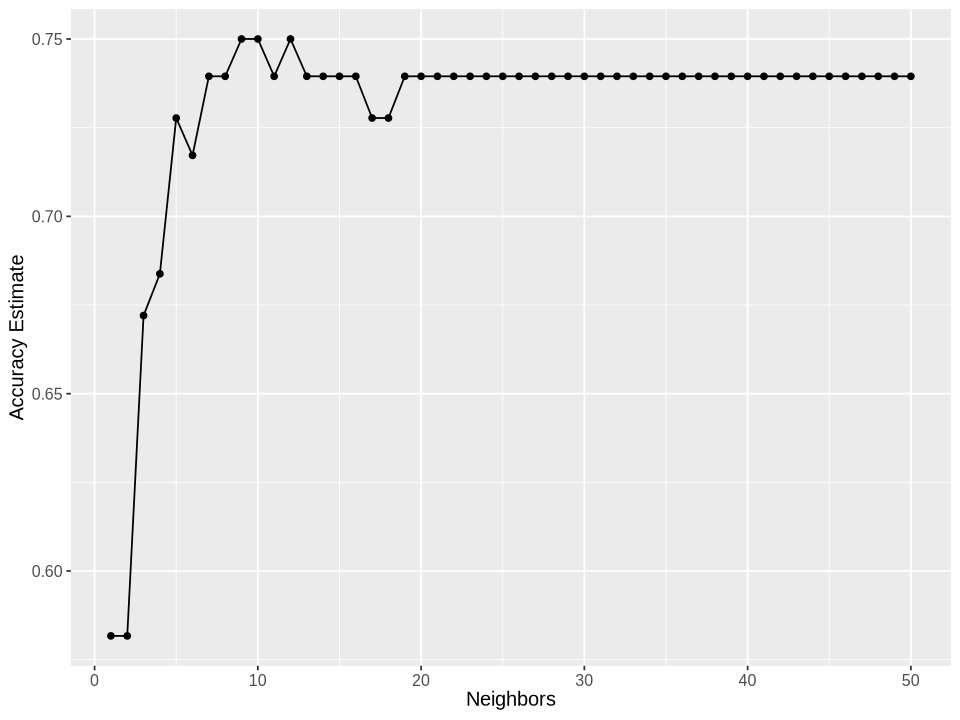

In [20]:
set.seed(69420)  # for reproducibility :3

data_split <- initial_split(merged_data, prop = 0.75) #splitting data into training and testing datasets (split by 0.75 and 0.25)
train_data <- training(data_split)
test_data  <- testing(data_split)


#creating a model specification for K-nearest neighbors classification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |> #using k nearest neighbors
  set_mode("classification") #our model type classification

#creating the centering and scaling the recipe (scaled the data so that all variables are on similar ranges, which helps KNN make more accurate distance predictions.)
train_recipe <- recipe(subscribe ~ Age + player_average_session_length + played_hours, data = train_data) |> #predicting subscribe using our predictors age, avg session length and total played hrs from our training data.
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

knn_fit <- workflow() |>
    add_recipe(train_recipe) |> #applies recipe
    add_model(knn_spec) |> #using knn classification model
    fit(data = train_data) #trains model using the train dataset 

data_test_predictions <- predict(knn_fit, test_data) |>
    bind_cols(test_data)

accuracy <- data_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy

precision <- data_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")
precision

recall <- data_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")
recall

merged_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_fit <- workflow() |>
    add_recipe(train_recipe) |>
    add_model(knn_spec) |> 
    fit_resamples(resamples = merged_vfold) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |> 
       set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |> 
    add_recipe(train_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = merged_vfold, grid = k_vals) |> 
    collect_metrics()

#knn_results

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
       geom_point() + 
       geom_line() + 
       labs(x = "Neighbors" , y = "Accuracy Estimate") + 
       theme(text = element_text(size = 12))

accuracy_vs_k


In [21]:

majority_classifer <- train_data |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(train_data)) |>
    filter(subscribe == "TRUE") |>
    pull()

print(paste0("Majority Classifier Accuracy: ", round(majority_classifer,2),"%"))


[1] "Majority Classifier Accuracy: 73.91%"


In [22]:
####GRAPHS####

# Creating a Density Plot for Players' Total Time Played
time_plot <- merged_data |>
    select(played_hours, subscribe) |>
    filter(played_hours >= 0, played_hours <= 20) |>
    ggplot(aes(x=played_hours, fill = subscribe, colour = subscribe)) + 
    geom_density(alpha = 0.5) +
    labs(title = "Density plot of Time Played (hours)", 
         x="Time Played (hours)",
         y="Density",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

# Creating a Density Plot for Players' Age
age_plot <- merged_data |>
    select(Age, subscribe) |>
    ggplot(aes(x=Age, fill = subscribe, colour = subscribe)) + 
    geom_density(alpha = 0.5) +
    labs(title = "Density plot of Player Age (years)", 
         x="Player Age (years)",
         y="Density",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

# Creating a Density Plot for Players' Average Session Length
session_length_plot <- merged_data |>
    select(player_average_session_length, subscribe) |>
    ggplot(aes(x=player_average_session_length, fill = subscribe, colour = subscribe)) + 
    geom_density(alpha = 0.5) +
    labs(title = "Density plot of Average Player Session Length (minutes)", 
         x="Average Session Length (minutes)",
         y="Density",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

# Creating a Scatter Plot of Player Average Session Length (minutes) vs Player Age (years)
plot_1 <- merged_data |>
    select(player_average_session_length, Age, played_hours, subscribe) |>
    ggplot(aes(x=Age, y= player_average_session_length, colour = subscribe)) +
    geom_point() +
    labs(title = "Scatter Plot of Player Average Session Length (minutes) vs Player Age (years)", 
         x="Player Age (years)",
         y="Player Average Session Length (minutes)",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

# Creating a Scatter Plot of Player's Total Playtime (hours) vs Player Age (years)
plot_2 <- merged_data |>
    select(player_average_session_length, Age, played_hours, subscribe) |>
    ggplot(aes(x=Age, y= played_hours, colour = subscribe)) +
    geom_point() +
    labs(title = "Scatter Plot of Player Total Playtime (hours) vs Player Age (years)", 
         x="Player Age (years)",
         y="Player's Total Playtime (hours)",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

# Creating a Scatter Plot of Player's Total Playtime (hours) vs Player Average Session Length (minutes)
plot_3 <- merged_data |>
    select(player_average_session_length, Age, played_hours, subscribe) |>
    ggplot(aes(x=player_average_session_length, y= played_hours, colour = subscribe)) +
    geom_point() +
    labs(title = "Scatter Plot of Player Total Playtime (hours) vs Player Average Session Length (minutes)", 
         x="Player Average Session Length (minutes)",
         y="Player's Total Playtime (hours)",
         fill = "Is Subscribed?", 
         colour = "Is Subscribed?")

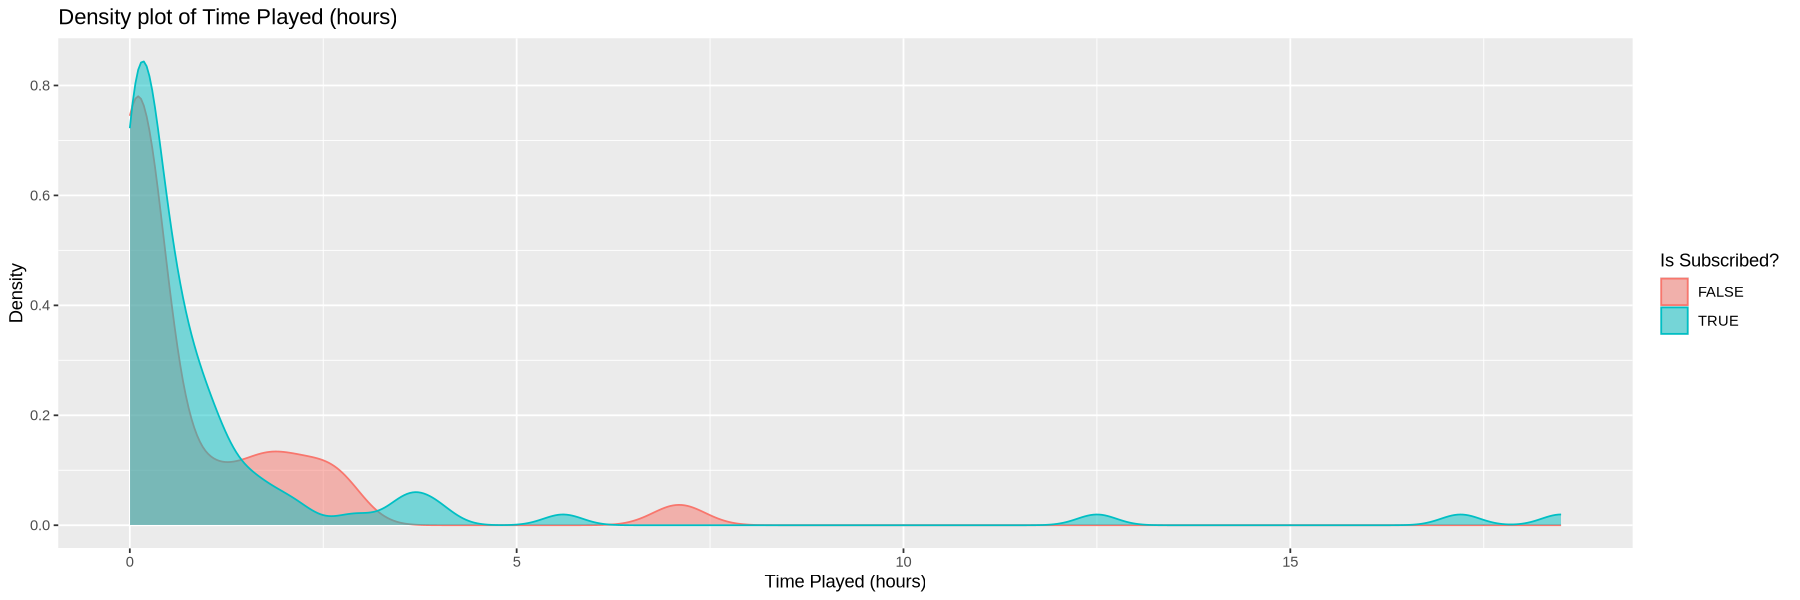

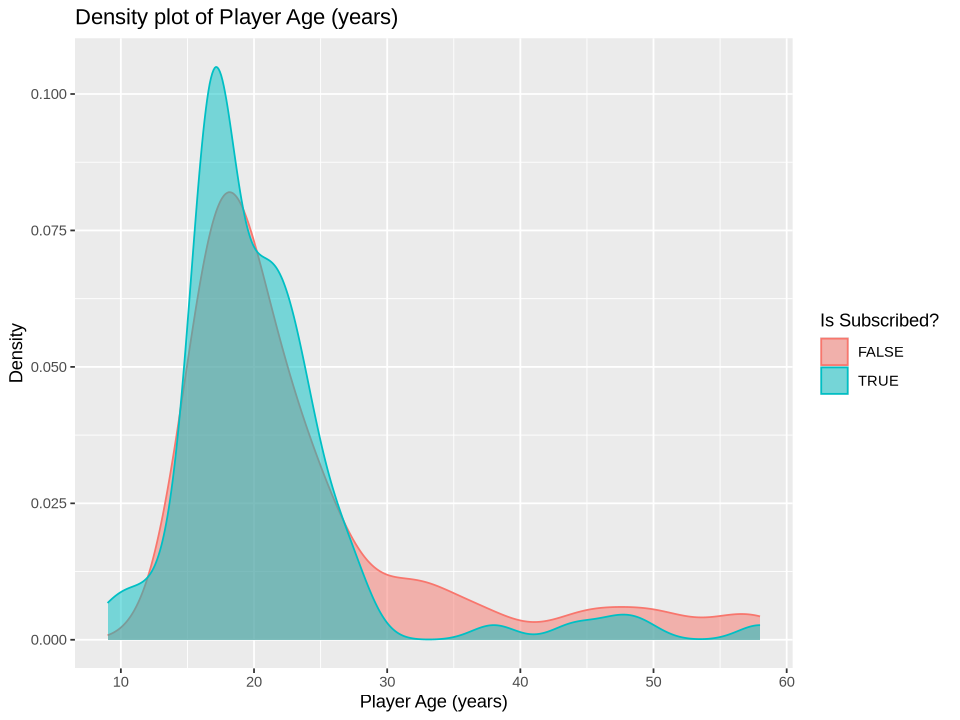

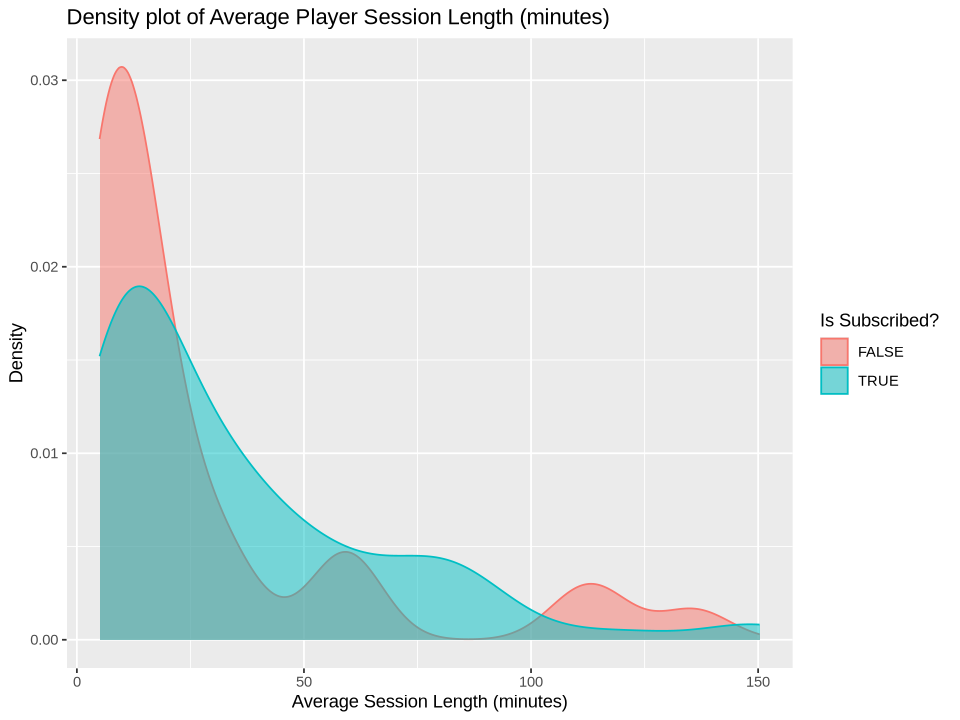

In [23]:
####DENSITY PLOTS####

options(repr.plot.width = 15, repr.plot.height = 5)
time_plot
options(repr.plot.width = 8, repr.plot.height = 6)
age_plot
session_length_plot

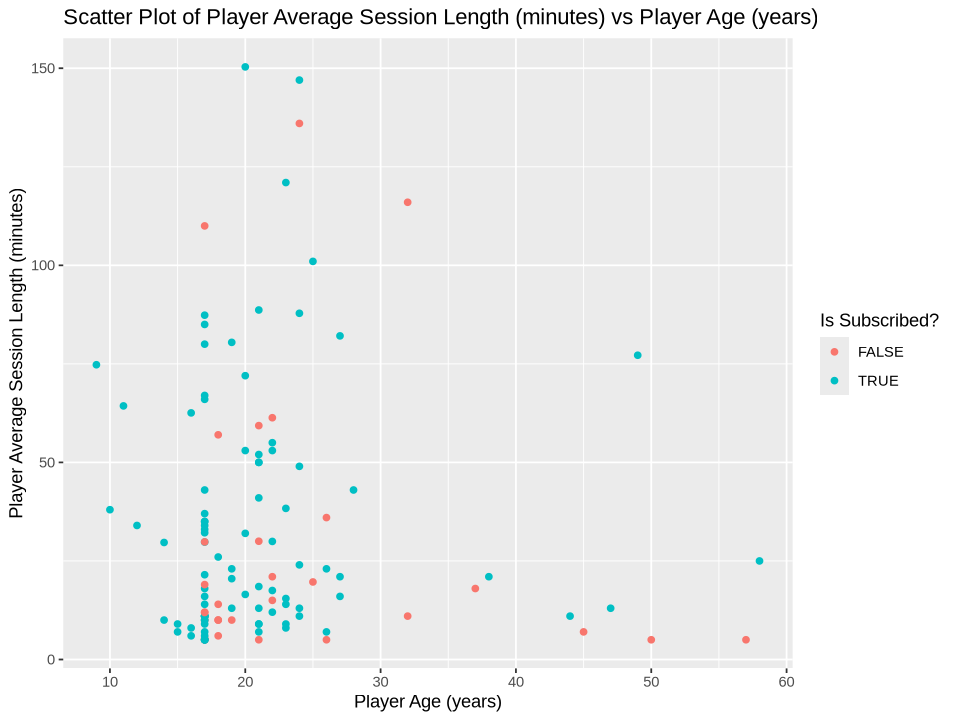

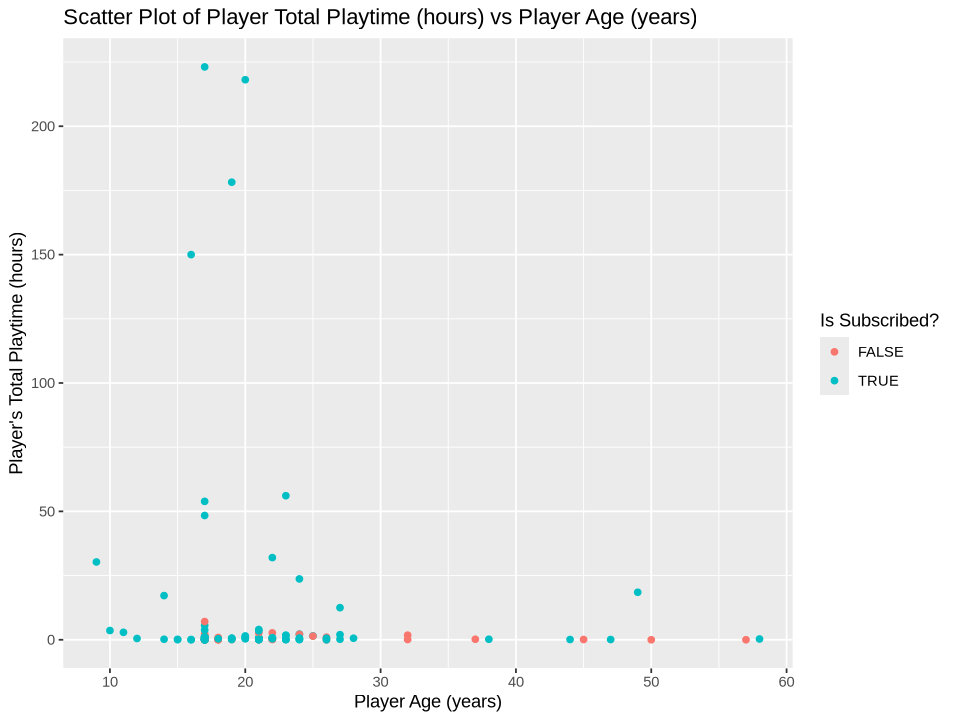

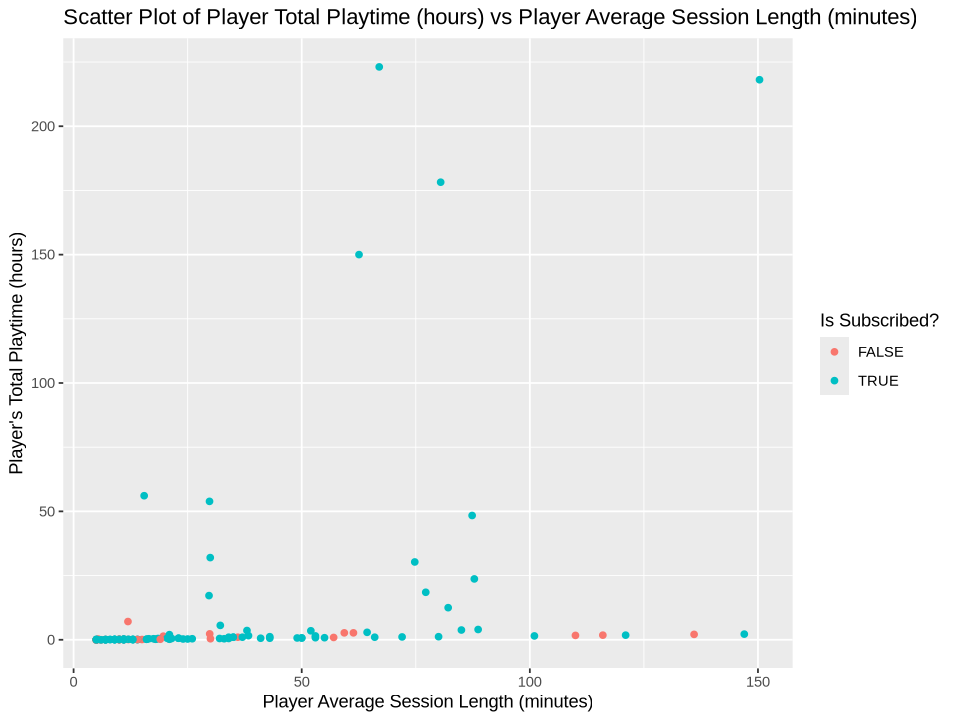

In [24]:
####SCATTER PLOTS####

options(repr.plot.width = 8, repr.plot.height = 6)
plot_1
plot_2
plot_3

# Discussion:

Our analysis found that although there were no strong linear relationships between age, average session length, and total play time, some patterns on the graph showed us differences between subscribers and non-subscribers. Players with any non zero total playtime were almost all subscribers of newsletters, and the L-shaped pattern between age and average session length indicated a non linear relationship. Density plots also showed that average session length differed more noticeably between groups, suggesting it may be the most useful variable for predicting a player's subscription.

These results were slightly unexpected. We thought that player behavior might have a connection to the subscription status, but were unsure about it forming clear trends. The subtle patterns we looked at align with this expectation behavior, but only slightly.

The main impact of these findings is that player activity can offer some predictive value, but not enough to be super accurate. This suggests that PLAI may need additional behavioral or demographic features maybe if they would like to target players who are likely to subscribe to newsletters.

Some future work that could be done could explore which additional variables like playing frequency, what time of the day trending patterns, or social activity could improve prediction. More data or more complex models may also tell us better insights. 